# 第四章　暖冷房設備 / Chapter 4 Heating and cooling equipment

## 第四節　FF暖房機 / Section 4 FF type heating

In [1]:
import numpy as np

from pyhees.section4_1 import get_virtual_heating_devices, calc_A_HCZ_i, get_alpha_UT_H_MR, get_alpha_UT_H_OR
from pyhees.section4_1_a import calc_heating_mode
from pyhees.section2_1 import get_f_prim
from pyhees.section2_2 import calc_heating_load
from pyhees.section3_1 import get_Q
from pyhees.section3_2 import calc_insulation_performance
from pyhees.section4_4 import calc_E_E_H_d_t, calc_E_G_H_d_t, calc_E_K_H_d_t, get_E_M_H_d_t, calc_Q_UT_H_d_t
from pyhees.section4_4_a import get_q_max_H, get_q_min_H, get_P_rtd_H, get_P_itm_H

## 試算例

### 初期条件

In [2]:
def get_default_ff_type_heating():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34}
    house_ENV = {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'method': '当該住宅の外皮面積の合計を用いて評価する'}

    H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
    H_OR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
    i = 1
    
    return house_base, house_ENV, H_MR, H_OR, i

### 計算

In [3]:
def calc_results(house_base, house_ENV, H_MR, H_OR, i):

    sol_region = None
    NV_MR = 0
    NV_OR = 0
    r_A_ufvnt = None
    underfloor_insulation = False
    TS = None
    HEX = None
    SHC = None
    fuel = "G"

    mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'
    mode_C = '居室のみを冷房する方式'

    house_ENV['A_A'] = house_base['A_A']


    # 外皮の断熱性能の計算
    if house_ENV is not None:
        U_A, _, _, _, Q_dash, eta_H, eta_C, _ = calc_insulation_performance(**house_ENV)
        # 熱損失係数
        Q = get_Q(Q_dash)
        A_env = house_ENV.get('A_env')
    else:
        Q = None
        eta_H, eta_C = None, None
        A_env = None

    
    # 実質的な暖房機器の仕様を取得
    spec_MR, spec_OR = get_virtual_heating_devices(house_base['region'], H_MR, H_OR)

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(region=house_base['region'], H_MR=spec_MR, H_OR=spec_OR)

    # 暖房負荷の取得
    L_T_H_d_t_i, _ = calc_heating_load(
        house_base['region'], sol_region, house_base['A_A'], house_base['A_MR'], house_base['A_OR'],
        Q, eta_H, eta_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX, underfloor_insulation, mode_H, mode_C,
        spec_MR, spec_OR, mode_MR, mode_OR, SHC)

    # 仕様の取得
    A_HCZ = calc_A_HCZ_i(i, house_base['A_A'], house_base['A_MR'], house_base['A_OR'])
    q_max_H = get_q_max_H(A_HCZ)
    q_min_H = get_q_min_H(q_max_H)
    P_rtd_H = get_P_rtd_H(q_max_H)
    P_itm_H = get_P_itm_H()
    e_rtd_H = H_MR["e_rtd_H"] if i == 1 else H_OR["e_rtd_H"]


    # 電気消費量
    E_E_H_d_t = calc_E_E_H_d_t(q_max_H, q_min_H, P_rtd_H, P_itm_H, L_H_d_t=L_T_H_d_t_i[i-1])

    # ガス消費量
    E_G_H_d_t = calc_E_G_H_d_t(fuel=fuel, q_max_H=q_max_H, e_rtd_H=e_rtd_H, L_H_d_t=L_T_H_d_t_i[i-1])

    # 灯油
    E_K_H_d_t = calc_E_K_H_d_t(fuel=fuel, q_max_H=q_max_H, e_rtd_H=e_rtd_H, L_H_d_t=L_T_H_d_t_i[i-1])

    # その他の燃料
    E_M_H_d_t = get_E_M_H_d_t()

    # 未処理暖房負荷の設計一次エネルギー消費量相当値
    Q_UT_H_d_t = calc_Q_UT_H_d_t(q_max_H, L_H_d_t=L_T_H_d_t_i[i-1])
    alpha_UT_H = get_alpha_UT_H_MR(house_base['region'], mode_MR) if i == 1 else get_alpha_UT_H_OR(house_base['region'], mode_OR)
    E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H

    # 電気の一次エネルギー換算係数
    f_prim = get_f_prim()

    E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
    print(f'E_H_d_t(i={i})={np.sum(E_H_d_t)}MJ/a')
    
    return E_H_d_t


In [4]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
_E_H_d_t_1 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=14330.938494398375MJ/a


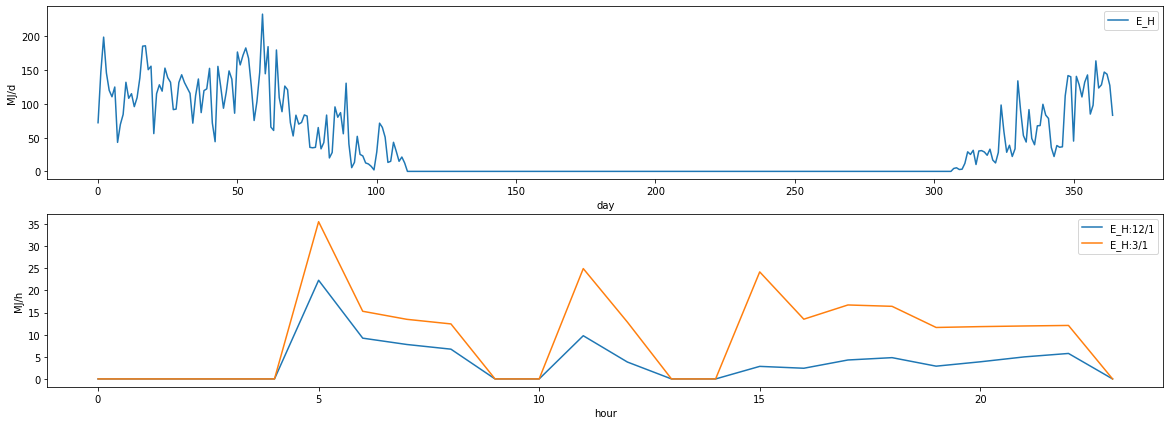

In [6]:
get_each_graph(_E_H_d_t_1)

### 計算条件2

- 地域区分を1地域に変更

In [7]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
house_base['region'] = 1

_E_H_d_t_2 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=55082.831191244426MJ/a


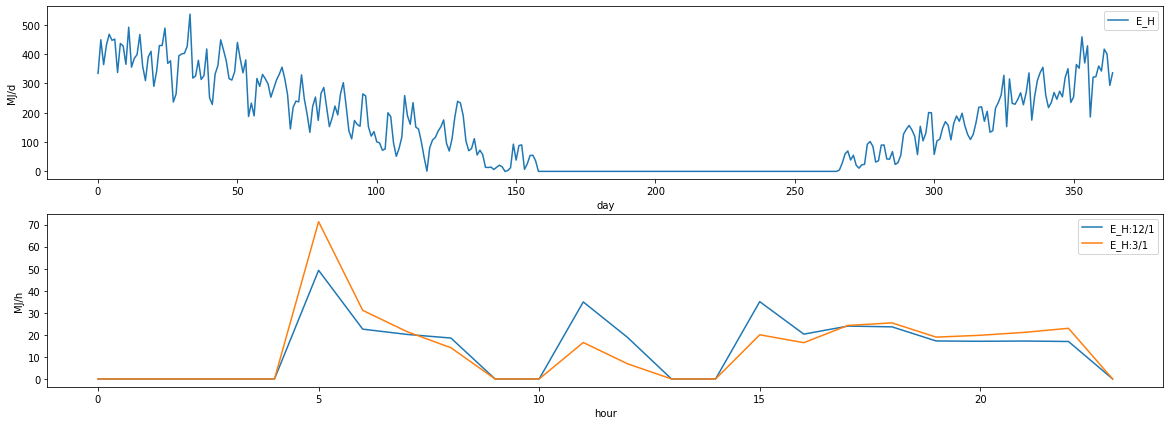

In [8]:
get_each_graph(_E_H_d_t_2)

### 計算条件3

- 住戸、主居室、その他居室の床面積を90m2、25m2、40m2に変更
- 外皮面積の合計を250m2に変更

In [9]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
house_base["A_A"] = 90
house_base["A_MR"] = 25
house_base["A_OR"] = 40
house_ENV["A_env"] = 250

_E_H_d_t_3 = calc_results(house_base, house_ENV, H_MR, H_OR, i)


E_H_d_t(i=1)=12926.604927421971MJ/a


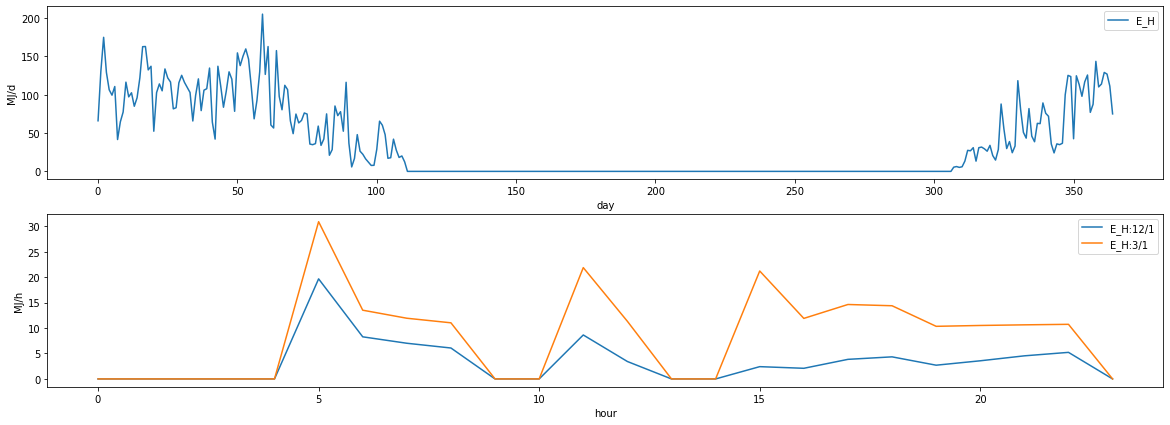

In [10]:
get_each_graph(_E_H_d_t_3)

### 計算条件4

- 外皮平均熱貫流率を0.6に変更

In [11]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
house_ENV['U_A'] = 0.6

_E_H_d_t_4 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=8952.37309634613MJ/a


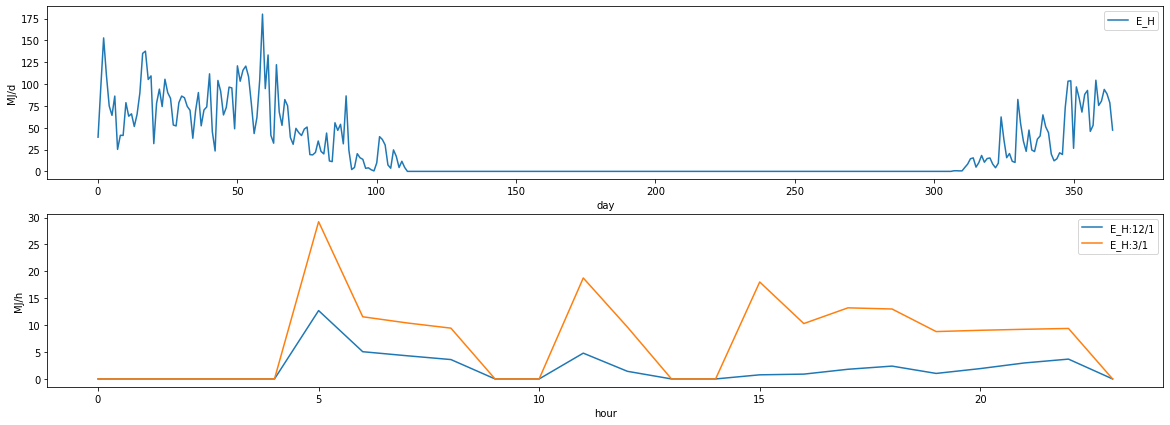

In [12]:
get_each_graph(_E_H_d_t_4)

### 計算条件5

- 暖房期平均日射熱取得率を3.0に変更

In [13]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
house_ENV['eta_A_H'] = 3.0

_E_H_d_t_5 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=17476.606193142656MJ/a


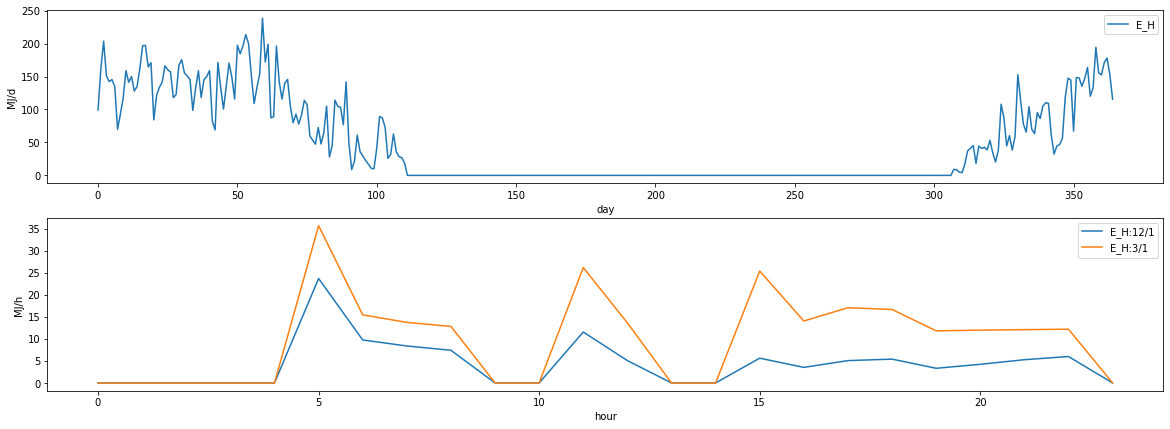

In [14]:
get_each_graph(_E_H_d_t_5)

### 計算条件6

- 冷房期平均日射熱取得率を2.0に変更

In [15]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
house_ENV['eta_A_C'] = 2.0

_E_H_d_t_6 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=14330.938494398375MJ/a


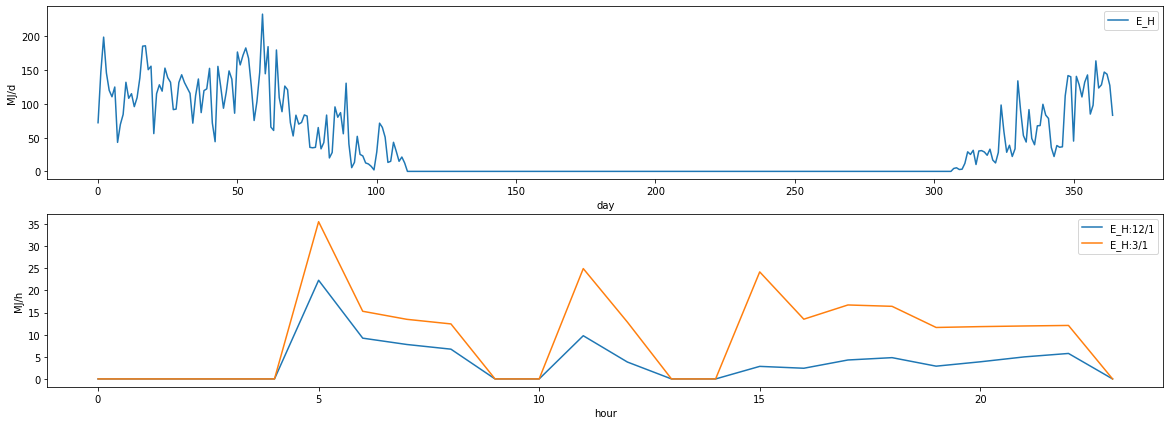

In [16]:
get_each_graph(_E_H_d_t_6)

### 計算条件7

- エネルギー消費効率を0.750に変更

In [17]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
H_MR['e_rtd_H'] = 0.750

_E_H_d_t_7 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=16292.88931854348MJ/a


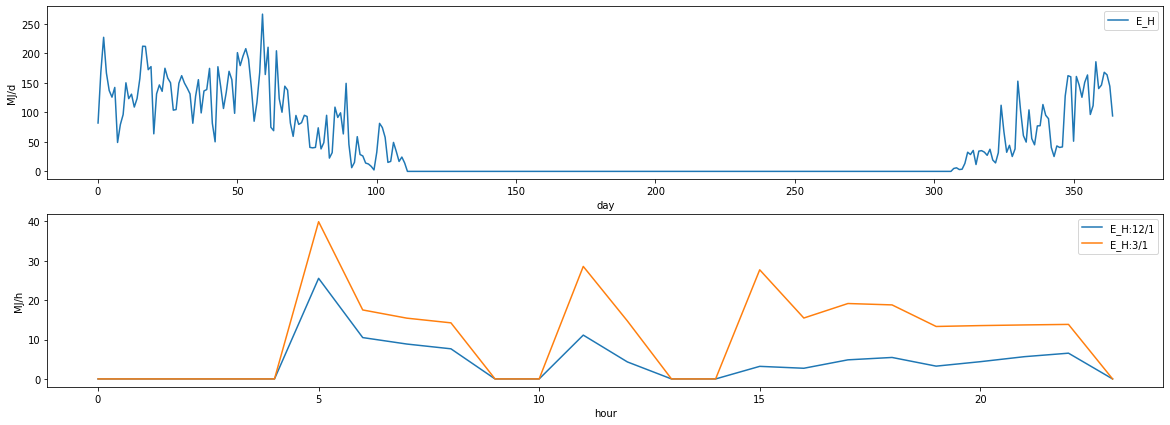

In [18]:
get_each_graph(_E_H_d_t_7)

### 計算条件8

- 暖冷房区画を4に変更

In [19]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
i = 4

_E_H_d_t_8 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=4)=2086.8994553484454MJ/a


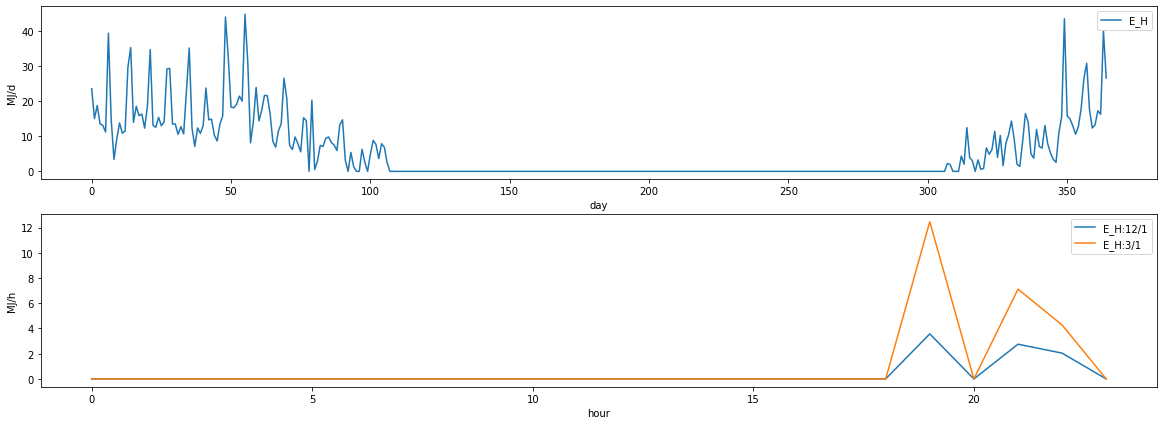

In [20]:
get_each_graph(_E_H_d_t_8)

### 計算条件9

- 暖冷房区画を5に変更

In [21]:
house_base, house_ENV, H_MR, H_OR, i = get_default_ff_type_heating()
i = 5

_E_H_d_t_9 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=5)=1896.1156808220217MJ/a


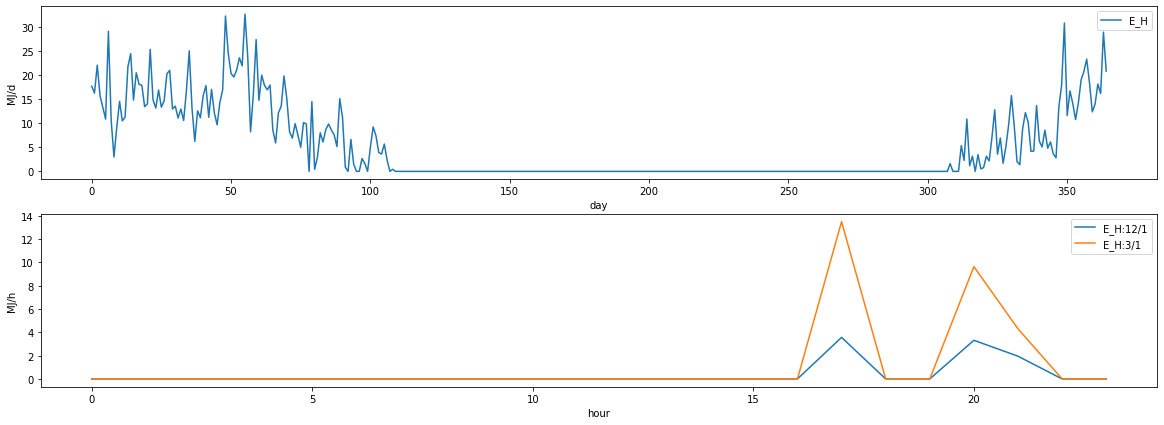

In [22]:
get_each_graph(_E_H_d_t_9)

## 試算例の比較

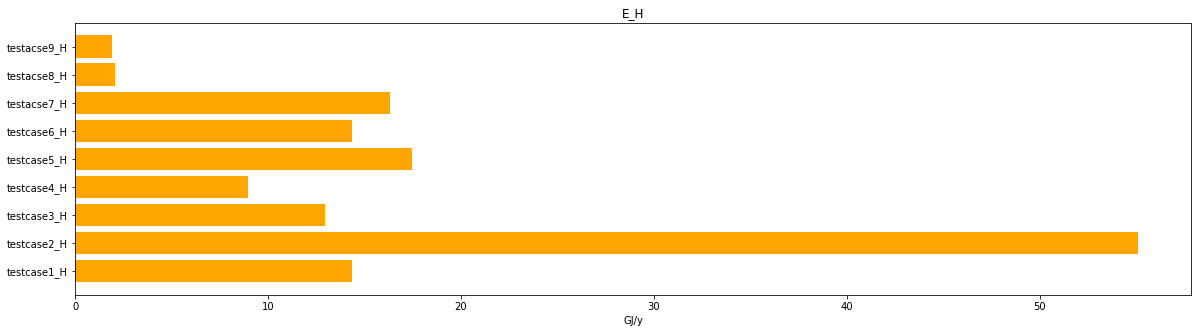

In [23]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000, "testcase6_H": np.sum(_E_H_d_t_6)/1000,
         "testacse7_H": np.sum(_E_H_d_t_7)/1000, "testacse8_H": np.sum(_E_H_d_t_8)/1000, "testacse9_H": np.sum(_E_H_d_t_9)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()